In [2]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                            accuracy_score, precision_score, recall_score, f1_score)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from time import time
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Mount Google Drive (persistent storage)
drive.mount('/content/drive')
# Load dataset (replace with your path)
file_path = '/content/drive/MyDrive/combined_dataset.csv'
data = pd.read_csv(file_path)


Mounted at /content/drive


In [4]:

# Data Preprocessing
print("Original shape:", data.shape)


Original shape: (18342022, 13)


In [5]:
# Handle missing values
data = data.dropna()
print("After dropping NA:", data.shape)


After dropping NA: (18342022, 13)


In [15]:
labels = data['Label'].unique()
print("Classes:", labels)

Classes: [1 0]


In [6]:

# Feature-Target Split
X = data.drop('Label', axis=1).values
y = data['Label'].values

# Train-Validation-Test Split (60-20-20)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


In [7]:

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [8]:
# Convert to PyTorch tensors
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.LongTensor(y_train)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.LongTensor(y_val)
X_test_t = torch.FloatTensor(X_test)
y_test_t = torch.LongTensor(y_test)


In [9]:
# Create DataLoaders
batch_size = 1024
train_data = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data = TensorDataset(X_val_t, y_val_t)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_data = TensorDataset(X_test_t, y_test_t)
test_loader = DataLoader(test_data, batch_size=batch_size)


In [16]:
# Neural Network Architecture
class BotNetDetector(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, len(labels))  # Output layer

        self.dropout = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(32)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)
        return x


In [17]:
# Initialize model
input_size = X_train.shape[1]
model = BotNetDetector(input_size)


In [18]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"Using device: {device}")


Using device: cpu


In [19]:
# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)


In [20]:
# Early stopping parameters
patience = 5
best_val_loss = float('inf')
counter = 0


In [23]:
# Training loop
epochs = 50
train_losses = []
val_losses = []
val_accuracies = []

print("\nStarting training...")
start_time = time()

for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        # Save best model
        torch.save(model.state_dict(), '/content/drive/MyDrive/botnet_nn_best.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_loss:.4f} - "
          f"Val Loss: {val_loss:.4f} - "
          f"Val Acc: {val_acc:.4f}")

training_time = time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds")




Starting training...
Epoch 1/50 - Train Loss: 0.0078 - Val Loss: 0.0087 - Val Acc: 0.9979
Epoch 2/50 - Train Loss: 0.0072 - Val Loss: 0.0141 - Val Acc: 0.9985
Epoch 3/50 - Train Loss: 0.0067 - Val Loss: 0.0077 - Val Acc: 0.9984
Epoch 4/50 - Train Loss: 0.0067 - Val Loss: 0.0081 - Val Acc: 0.9985
Epoch 5/50 - Train Loss: 0.0064 - Val Loss: 0.0073 - Val Acc: 0.9986
Epoch 6/50 - Train Loss: 0.0063 - Val Loss: 0.0073 - Val Acc: 0.9985
Epoch 7/50 - Train Loss: 0.0062 - Val Loss: 0.0052 - Val Acc: 0.9985
Epoch 8/50 - Train Loss: 0.0062 - Val Loss: 0.0059 - Val Acc: 0.9985
Epoch 9/50 - Train Loss: 0.0061 - Val Loss: 0.0061 - Val Acc: 0.9986
Epoch 10/50 - Train Loss: 0.0061 - Val Loss: 0.0066 - Val Acc: 0.9986
Epoch 11/50 - Train Loss: 0.0061 - Val Loss: 0.0050 - Val Acc: 0.9987
Epoch 12/50 - Train Loss: 0.0061 - Val Loss: 0.0062 - Val Acc: 0.9986
Epoch 13/50 - Train Loss: 0.0061 - Val Loss: 0.0049 - Val Acc: 0.9986
Epoch 14/50 - Train Loss: 0.0061 - Val Loss: 0.0115 - Val Acc: 0.9985
Epoch 1

In [25]:
# Load best model
model.load_state_dict(torch.load('/content/drive/MyDrive/botnet_nn_best.pth'))
model.eval()


BotNetDetector(
  (fc1): Linear(in_features=12, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [26]:
# Evaluation on test set
y_true = []
y_pred = []
y_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_probs = np.array(y_probs)[:, 1]  # Probability of positive class


In [27]:
# Metrics
print("\n=== Test Set Performance ===")
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_true, y_pred):.4f}")



=== Test Set Performance ===
Accuracy: 0.9986
Precision: 0.9988
Recall: 0.9998
F1-Score: 0.9993


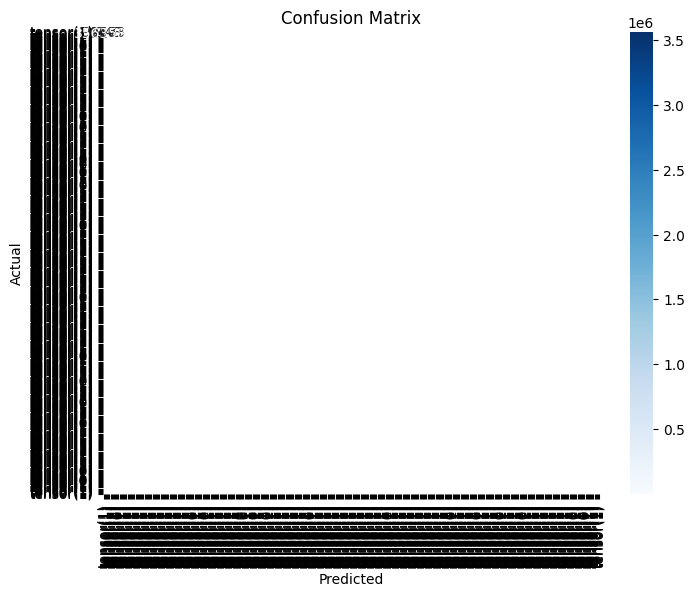

In [28]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [31]:
# Classification Report
print("\n=== Classification Report ===")


print(classification_report(y_true, y_pred, target_names=['0', '1']))



=== Classification Report ===
              precision    recall  f1-score   support

           0       0.99      0.96      0.97    104006
           1       1.00      1.00      1.00   3564399

    accuracy                           1.00   3668405
   macro avg       1.00      0.98      0.99   3668405
weighted avg       1.00      1.00      1.00   3668405



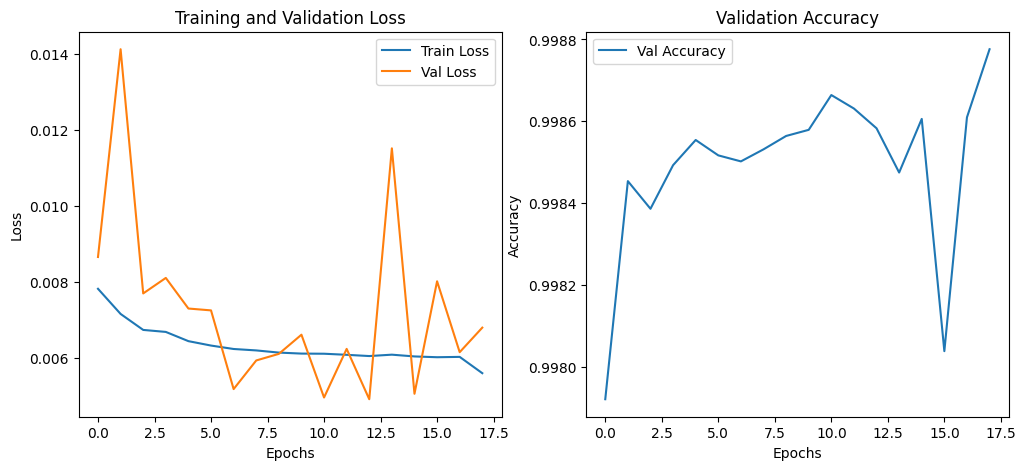

In [32]:
# Plot training history
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()